# Modeling - First Pass

### Installs, Packages, Seeds

In [71]:
# %pip install efficientnet_pytorch

In [4]:
%pip install torch==1.13.0

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached torch-1.13.0-cp38-cp38-manylinux1_x86_64.whl (890.2 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch

OSError: /home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/torch/lib/../../nvidia/cublas/lib/libcublas.so.11: symbol cublasLtHSHMatmulAlgoInit, version libcublasLt.so.11 not defined in file libcublasLt.so.11 with link time reference

In [1]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
# from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

# custom modeling libraries
from build_model import initialize_model, load_split_data, build_loader, evaluate, train_model

# other
import importlib

OSError: /home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/torch/lib/../../nvidia/cublas/lib/libcublas.so.11: symbol cublasLtHSHMatmulAlgoInit, version libcublasLt.so.11 not defined in file libcublasLt.so.11 with link time reference

In [ ]:
# import build_model
# importlib.reload(build_model)

# from build_model import initialize_model, load_split_data, build_loader, evaluate, train_model

# import matplotlib as mpl
# print(mpl.get_cachedir())

## Parameters

In [4]:
model_dict = {'pretrained_model': 'resnet',
              'epochs': 3,
              'home_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone',
              'mod_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone/model',
              'csv_name': 'full_data_rename',
              'split': 'split_3',
              'cl': 'label_0',
              'dev_state': False,
              'dev_sample': 15000,
              'seed': 99,
              'lr': .002,
              'batch_size':64,
              'num_workers':24,
             }

np.random.seed(model_dict['seed'])
torch.cuda.manual_seed(model_dict['seed'])

# Check GPU
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

GPU Type: Tesla T4
GPU Count: 1


## Data

In [5]:
data, train, test, val = load_split_data(directory = model_dict['home_directory'],
                                         csv_name = model_dict['csv_name'], 
                                         data_split = model_dict['split'], 
                                         label = model_dict['cl'],
                                         mode = 'all',
                                         dev_state = model_dict['dev_state'], 
                                         dev_sample = model_dict['dev_sample'], 
                                         seed = model_dict['seed']
                                         )

## Modeling

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name = model_dict['pretrained_model'], 
                                        num_classes = len(data.label.unique()),
                                        feature_extract = False, 
                                        use_pretrained=True)

# Define GPU:
device = torch.device('cuda:0')

# Move model to GPU
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

After model is defined, add final Parameters

In [ ]:
# add some params after model definition
model_dict.update({'model':model,
                   'device':device,
                   'optimizer': optim.SGD(model.parameters(), lr=model_dict['lr']),
                   'criterion': nn.CrossEntropyLoss().to(device),
                   'tuned_model_name':'resnet_split3_3e_Ta',})

In [ ]:
# using torch vision 'transforms'
train_transform = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224), #224
#                                       transforms.RandomHorizontalFlip(), # a
                                    #   transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                    #   transforms.RandomCrop(size=(input_size,input_size)),
#                                       transforms.RandomInvert(), transforms.RandomPosterize(bits=2),
#                                       transforms.RandomAdjustSharpness(sharpness_factor=2),
#                                       transforms.RandomSolarize(threshold=192.0),
#                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                      ])
# define the transformation of the val images. also used for test
val_transform = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                    ])

### Assemble data loaders

In [ ]:
train_loader = build_loader(mode = 'train', df = train, transform = train_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
test_loader = build_loader(mode = 'test', df = test, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
val_loader = build_loader(mode = 'val', df = val, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])

loaders = {'train_loader':train_loader,
                        'val_loader': val_loader,
                        'test_loader': test_loader}
model_dict['loader'] = loaders

Run the model

In [ ]:
HOME = model_dict['home_directory']

In [ ]:
cd $HOME

## Train Sequence

In [ ]:
train_model(model_dict = model_dict)

## Evaluate

In [84]:
# Label dictionary for evaluation
labels_idx = np.sort(data.label_idx.unique())
label_map = data[['label', 'label_idx']].drop_duplicates().sort_values('label_idx')
label_dict = dict(zip(label_map.label_idx, label_map['label']))

------------------------------------------------------------
[epoch test], [test loss 1.06911], [test acc 0.57328]
------------------------------------------------------------


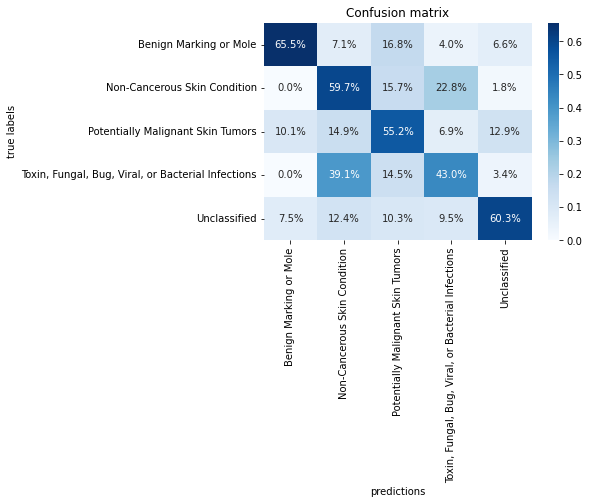

In [85]:
pred_df = evaluate(model_name = model_dict['tuned_model_name'], 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

Write predictions and labels to CSV

In [86]:
direc = model_dict['mod_directory']
nam = model_dict['tuned_model_name']
pred_df.to_pickle(f'{direc}/{nam}_preds.pkl')

In [88]:
# d = pd.read_pickle(f'{direc}/{nam}_preds.pkl')